In [119]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

import torch.nn.functional as F
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

from optimizers import DiscreteStateOptimizer


In [120]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Hyperparameters
input_size = 28
num_classes = 10
batch_size = 1024

dataset_name = ["MNIST", "FashionMNIST"][0]


In [121]:
class CustomDataset(Dataset):
    def __init__(self, name:str, root:str, train:bool, transform:transforms.Compose, download=False):
        
        dataset_class = getattr(datasets, name)
        self.mnist_dataset = dataset_class(root=root, train=train, transform=transform, download=download)\
        
        # Preload the images and labels onto the GPU
        self.data = self.mnist_dataset.data.unsqueeze(1).float()  # Add channel dimension for grayscale
        self.labels = self.mnist_dataset.targets
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.transform = transform
        if self.transform:
            self.data = torch.stack([self.transform(image) for image in self.data])
        
        # Move the data and labels to GPU
        self.data = self.data.to(self.device)
        self.labels = self.labels.to(self.device)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return self.data[idx], self.labels[idx]


# Transforms for the dataset (resize to (image_size X image_size) and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((input_size, input_size))
])

# Create custom datasets
train_dataset = CustomDataset(root='./data/', name=dataset_name , train=True, transform=transform, download=True)
test_dataset = CustomDataset(root='./data/', name=dataset_name, train=False, transform=transform, download=True)

# Create DataLoaders (no need for shuffling if data is preloaded to GPU)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


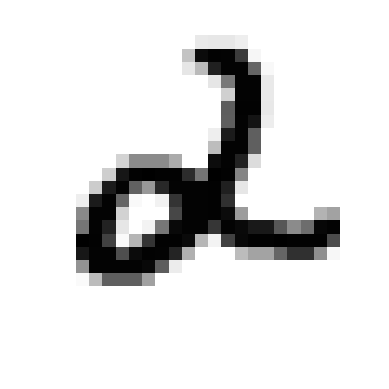

torch.Size([28, 28])


In [122]:
plt.imshow(1-train_dataset[8097][0][0].cpu(), cmap='gray')
plt.axis('off')
plt.show()
print(train_dataset[7][0][0].cpu().shape)

In [123]:

def load_data(file_path, column, rows=None):
    """Generic function to load data from an Excel file."""
    df = pd.read_excel(file_path)
    return list(df[column][:rows]) if rows else list(df[column])

potentiation_datasets = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "potentiation (mS)", 30),
    "vivek": ("data/new_data_50_pulses.xlsx", "Potentiation", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Conductance", 128)
}

# Select potentiation data
data_choice = "himanshu" 

finite_set = load_data(*potentiation_datasets.get(data_choice, (None, None, None)))



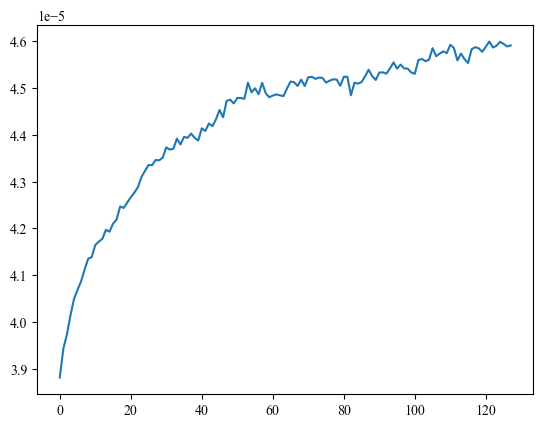

In [124]:
plt.plot(finite_set)

In [125]:

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.05): 
        super(SimpleCNN, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # First convolution layer
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Second convolution layer
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling layer
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer with specified probability

        # Fully connected layer
        out_size = {
            28:7,
            20:5,
            14:3
        }
        self.fc1 = nn.Linear(64 * out_size[input_size] * out_size[input_size], num_classes)  # Adjust 7x7 based on the input size and pooling

      


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.pool(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)  

        # Pass through the fully connected layer
        x = self.fc1(x)
        return x
    


class MLP(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super(MLP, self).__init__()
        hidden_size = 512
        self.fc = nn.Linear(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.act = nn.ELU()
        self.softmax = nn.Softmax(dim=-1)
        

    def forward(self, x):
        x = x.view(x.size(0), -1)    # Flatten the input
        x = self.act(self.fc(x))
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        # x = self.softmax(x)
        return x


In [126]:
# Initialize model, loss, and optimizer
model = SimpleCNN(num_classes).to(device)
# model = MLP(input_size**2, num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#  CNN Optimizer
optimizer = DiscreteStateOptimizer(model.parameters(), conductance_list=finite_set, tau=0.003)


# MLP Optimizer
# optimizer = DiscreteStateOptimizer(model.parameters(), conductance_list=finite_set, tau=0.0003)

# temporary optimizers
# optimizer = DiscreteStateOptimizer(model.parameters(), conductance_list=finite_set, tau=0.005)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

# Performance metrics
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision_metric = Precision(task="multiclass", num_classes=num_classes, average='weighted').to(device)
recall_metric = Recall(task="multiclass", num_classes=num_classes, average='weighted').to(device)
f1_score_metric = F1Score(task="multiclass", num_classes=num_classes, average='weighted').to(device)
loss_arr = []

metric_lists = {
    "accuracy":[],
    "precision":[],
    "recall":[],
    "fscore":[]
}

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)


Total number of parameters: 50378


In [127]:

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        model.train()
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets) 
        total_loss += loss.item()
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        if batch_idx % 10 == 0:
            # model.eval()
            accuracy_metric.reset()
            precision_metric.reset()
            recall_metric.reset()
            f1_score_metric.reset()

            with torch.no_grad():
                for data, targets in test_loader:
                    # data, targets = data.to(device), targets.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)

                    # Update metrics
                    accuracy_metric.update(predicted, targets)
                    precision_metric.update(predicted, targets)
                    recall_metric.update(predicted, targets)
                    f1_score_metric.update(predicted, targets)
            
            metric_lists['accuracy'].append(accuracy_metric.compute().item())
            metric_lists['recall'].append(recall_metric.compute().item())
            metric_lists['precision'].append(precision_metric.compute().item())
            metric_lists['fscore'].append(f1_score_metric.compute().item())
    loss_arr.append(total_loss)

    
    # Reset metrics
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_score_metric.reset()


    if (epoch+1)%1 == 0:
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            for data, targets in test_loader:
                # data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)

                # Update metrics
                accuracy_metric.update(predicted, targets)
                precision_metric.update(predicted, targets)
                recall_metric.update(predicted, targets)
                f1_score_metric.update(predicted, targets)

        # Compute and print metrics
        accuracy = accuracy_metric.compute().item()
        precision = precision_metric.compute().item()
        recall = recall_metric.compute().item()
        f1_score = f1_score_metric.compute().item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/(50000/batch_size):.4f}, "
            f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
        





Epoch [1/20], Loss: 9.1922, Accuracy: 0.9422, Precision: 0.9452, Recall: 0.9422, F1 Score: 0.9414
Epoch [2/20], Loss: 0.4071, Accuracy: 0.9589, Precision: 0.9605, Recall: 0.9589, F1 Score: 0.9589
Epoch [3/20], Loss: 0.2492, Accuracy: 0.9768, Precision: 0.9770, Recall: 0.9768, F1 Score: 0.9768
Epoch [4/20], Loss: 0.2112, Accuracy: 0.9729, Precision: 0.9733, Recall: 0.9729, F1 Score: 0.9728
Epoch [5/20], Loss: 0.1884, Accuracy: 0.9782, Precision: 0.9783, Recall: 0.9782, F1 Score: 0.9782
Epoch [6/20], Loss: 0.1587, Accuracy: 0.9771, Precision: 0.9775, Recall: 0.9771, F1 Score: 0.9771
Epoch [7/20], Loss: 0.1525, Accuracy: 0.9794, Precision: 0.9795, Recall: 0.9794, F1 Score: 0.9794
Epoch [8/20], Loss: 0.1461, Accuracy: 0.9270, Precision: 0.9450, Recall: 0.9270, F1 Score: 0.9269
Epoch [9/20], Loss: 0.1145, Accuracy: 0.9801, Precision: 0.9802, Recall: 0.9801, F1 Score: 0.9801
Epoch [10/20], Loss: 0.1039, Accuracy: 0.9819, Precision: 0.9820, Recall: 0.9819, F1 Score: 0.9819
Epoch [11/20], Loss

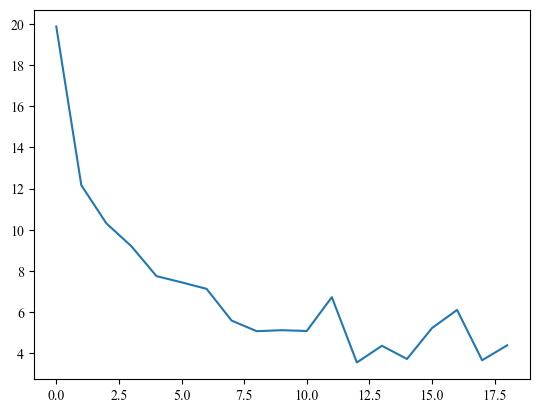

In [133]:
plt.plot(loss_arr[1:])

(89,)


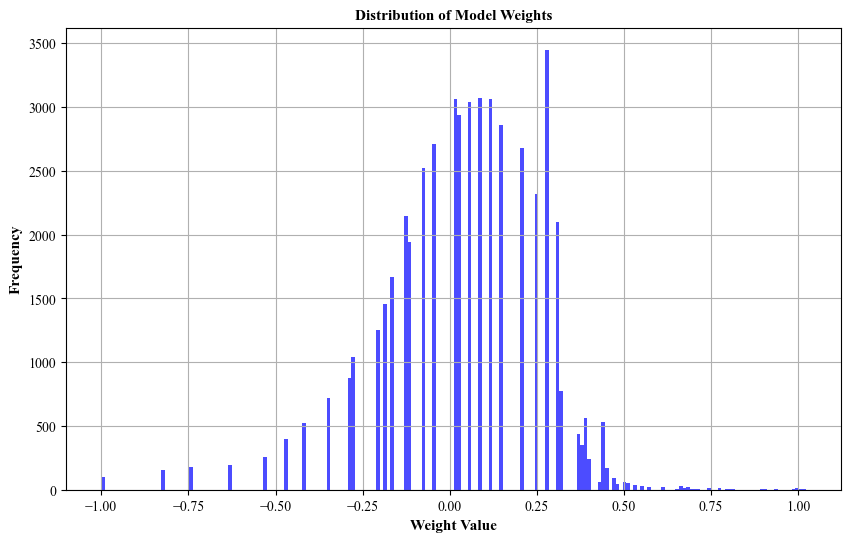

In [134]:
def plot_model_grads_histogram(model):
    # Collect all weights in the model
    all_weights = []
    for name, param in model.named_parameters():
        # if 'weight' in name:  # only take weights, ignore biases
        
        #     print(name, param)
        all_weights.extend(param.data.cpu().numpy().flatten())
    print(np.unique(all_weights).shape)
    # Plot the histogram
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(figsize=(10, 6))
    plt.hist(all_weights, bins=200, color='blue', alpha=0.7)
    plt.title('Distribution of Model Weights', {"size": 11, "family": "Times New Roman", "weight": "bold"})
    plt.xlabel('Weight Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
    plt.ylabel('Frequency', {"size": 11, "family": "Times New Roman", "weight": "bold"})
    plt.grid(True)
    plt.show()

plot_model_grads_histogram(model=model)

C:\Users\adith\AppData\Local\Temp\ipykernel_34668\1742141041.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


Test Accuracy: 0.981500%
Test Precision: 0.981636%
Test Recall: 0.981500%
Test F1 Score: 0.981499


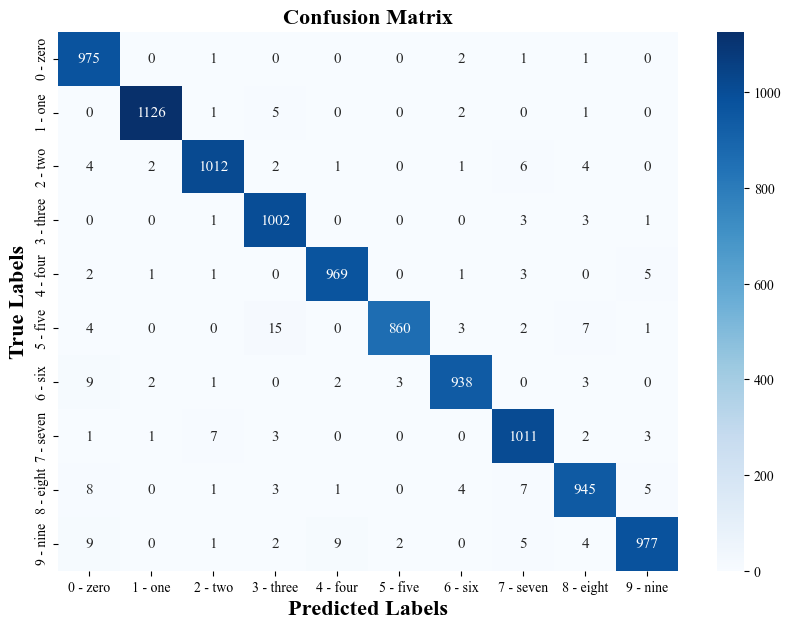

In [135]:


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels

all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)
# all_labels = all_labels.argmax(dim=1)
# Calculate metrics
test_accuracy = accuracy_metric(all_preds, all_labels)
test_precision = precision_metric(all_preds, all_labels)
test_recall = recall_metric(all_preds, all_labels)
test_f1 = f1_score_metric(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy :.6f}%')
print(f'Test Precision: {test_precision:.6f}%')
print(f'Test Recall: {test_recall:.6f}%')
print(f'Test F1 Score: {test_f1:.6f}')
# print("Confusion Matrix:")
# print(test_confusion_matrix)

plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 7))
sns.heatmap(test_confusion_matrix.cpu(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.mnist_dataset.classes, 
            yticklabels=train_dataset.mnist_dataset.classes,
            annot_kws={"size": 11, "family": "Times New Roman"})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=16, fontweight='bold')
plt.ylabel('True Labels', fontsize=16, fontweight='bold')
plt.show()

In [136]:
x = np.argmax(metric_lists['fscore'])

metric_lists['accuracy'][x], metric_lists['precision'][x], metric_lists['recall'][x], metric_lists['fscore'][x]

(0.9839000105857849,
 0.9839259386062622,
 0.9839000105857849,
 0.9838978052139282)

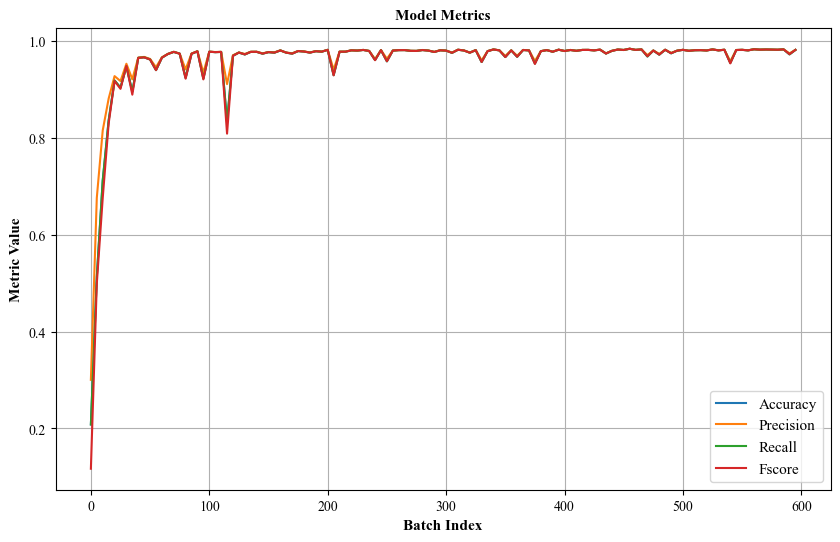

In [137]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

for metric, values in metric_lists.items():
    plt.plot([5*i for i in range(len(values))], values, label=metric.capitalize())



# Add title, labels, and legend
plt.title('Model Metrics', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Batch Index', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()